In [59]:
! pip install pandas
! pip install joblib
! pip install sklearn
! pip install catboost
! pip install seaborn

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from joblib import delayed, Parallel

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score, matthews_corrcoef
from catboost import CatBoostClassifier, Pool, sum_models
from sklearn.model_selection._split import _BaseKFold


In [2]:
suffixes = ['_se', '_re']
pays = pd.read_csv('data/pays.csv')
inn = pd.read_csv('data/inn_info_public.csv')
merged_pays = pd.merge(pays, inn, how='inner', left_on='hash_inn_kt', right_on='hash_inn')
merged_pays = pd.merge(
    merged_pays, inn, how='inner',
    left_on='hash_inn_dt', right_on='hash_inn',
    suffixes=suffixes
)
merged_pays.drop(columns=['hash_inn_kt', 'hash_inn_dt'], inplace=True)
suffixes = [suffix[1:] for suffix in suffixes]

In [3]:
class FeatureGenerator(object):
    def __init__(self, n_jobs=1, df=None, suffixes=None, key_param=None):
        self.n_jobs = n_jobs
        self.df = df
        self.suffixes = suffixes
        self.key_param = key_param

    def read_chunks(self):
        for suffix in self.suffixes:
            column = f'{self.key_param}_{suffix}'
            for id, user_sample in self.df.groupby(column, sort=False):
                yield id, user_sample, column

    def get_features(self, row):
        return self.features(row)

    def find_most_popular_column(self, row, pays, filtered_suffix, search_suffix):
        inn = row.name
        filtered_column_name = f'{self.key_param}_{filtered_suffix}'
        search_column_name = f'{self.key_param}_{search_suffix}'
        filtered_pays = pays[pays[filtered_column_name] == inn]
        if len(filtered_pays) > 0:
            return filtered_pays[search_column_name].value_counts().idxmax()
        return -1

    def features(self, inn: int, inn_sample, column: str):
        feature_dict = defaultdict(dict)
        prefix = column.split('_')[-1]
        feature_dict[inn]['okved'] = inn_sample[f'okved2_{prefix}'].iloc[0]
        number_of_records = inn_sample.shape[0]
        positive_sum_sample = inn_sample[inn_sample['sum'] >= 0]
        negative_sum_sample = inn_sample[inn_sample['sum'] < 0]
        same_region = inn_sample[inn_sample[f'region_{self.suffixes[0]}'] == inn_sample[f'region_{self.suffixes[1]}']]
        feature_dict[inn][f'region'] = inn_sample[f'region_{prefix}'].iloc[0]
        feature_dict[inn][f'{prefix}_positive_sum_percent'] = (positive_sum_sample.shape[0] / number_of_records) * 100
        feature_dict[inn][f'{prefix}_positive_sum'] = positive_sum_sample['sum'].sum()
        feature_dict[inn][f'{prefix}_negative_sum_percent'] = (negative_sum_sample.shape[0] / number_of_records) * 100
        feature_dict[inn][f'{prefix}_negative_sum'] = inn_sample[inn_sample['sum'] < 0]['sum'].sum()
        feature_dict[inn][f"{prefix}_sales_is_same_region"] = (same_region.shape[0] / inn_sample.shape[0]) * 100
        feature_dict[inn][f"{prefix}_sales_is_not_same_region"] = 100.00 - feature_dict[inn][f"{prefix}_sales_is_same_region"]
        feature_dict[inn][f"{prefix}_accum_sum"] = inn_sample['sum'].sum()
        feature_dict[inn][f"{prefix}_sum_min"] = inn_sample['sum'].min()
        feature_dict[inn][f"{prefix}_sum_max"] = inn_sample['sum'].max()
        feature_dict[inn][f"{prefix}_sum_mean"] = inn_sample['sum'].mean()
        feature_dict[inn][f"{prefix}_sum_25_percentile"] = inn_sample['sum'].quantile(0.25)
        feature_dict[inn][f"{prefix}_sum_std"] = inn_sample['sum'].std()
        feature_dict[inn][f"{prefix}_sum_75_percentile"] = inn_sample['sum'].quantile(0.75)
        feature_dict[inn][f'{prefix}_count_sum'] = inn_sample['count'].sum()
        feature_dict[inn][f'{prefix}_count_mean'] = inn_sample['count'].mean()
        feature_dict[inn][f'{prefix}_count_min'] = inn_sample['count'].min()
        feature_dict[inn][f'{prefix}_count_max'] = inn_sample['count'].max()
        feature_dict[inn][f'{prefix}_sum_across_week_mean'] = feature_dict[inn][f"{prefix}_sum_mean"] / feature_dict[inn][
            f'{prefix}_count_sum']
        feature_dict[inn][f'{prefix}_week_count'] = inn_sample['week'].nunique()
        if prefix == self.suffixes[0]:
            feature_dict[inn][f'{prefix}_number_of_clients'] = inn_sample[f'hash_inn_{self.suffixes[1]}'].nunique()
            feature_dict[inn][f'{prefix}_number_of_regions'] = inn_sample[f'region_{self.suffixes[1]}'].nunique()
        else:
            feature_dict[inn][f'{prefix}_number_of_clients'] = inn_sample[f'hash_inn_{self.suffixes[0]}'].nunique()
            feature_dict[inn][f'{prefix}_number_of_regions'] = inn_sample[f'region_{self.suffixes[0]}'].nunique()
        feature_dict[inn][f'{prefix}_week_count'] = inn_sample['week'].nunique()
        feature_dict[inn][f"{prefix}_records_count"] = number_of_records
        self.postprocessing(feature_dict[inn])
        return feature_dict

    def postprocessing(self, features: dict):
        for column, value in features.items():
            if isinstance(value, float):
                features[column] = round(value, 2)

    def generate(self, pays, prefix_1, prefix_2):
        feature_list = defaultdict(dict)
        results = Parallel(n_jobs=self.n_jobs, backend='loky')(delayed(self.features)(inn, inn_sample, column)
                                                               for inn, inn_sample, column in self.read_chunks())
        for result in results:
            for inn, features in result.items():
                feature_list[inn].update(features)
        feature_df = pd.DataFrame(feature_list).T
        feature_df = feature_df.fillna(0)
        feature_df[f'{self.suffixes[0]}_most_popular_client'] = feature_df.apply(
            lambda row: self.find_most_popular_column(row, pays, prefix_1, prefix_2), axis=1)
        feature_df[f'{self.suffixes[1]}_most_popular_client'] = feature_df.apply(
            lambda row: self.find_most_popular_column(row, pays, prefix_2, prefix_1 ), axis=1)
        return feature_df


In [ ]:
fg = FeatureGenerator(n_jobs=4, df=merged_pays, suffixes=suffixes, key_param='hash_inn')
features = fg.generate(pays, 'kt', 'dt')

In [ ]:
features.to_csv('features.csv')

In [79]:
features = pd.read_csv('features.csv', index_col='Unnamed: 0')

In [80]:
features.region = features.region.astype(int)
X = features[features.okved != -1]
y = X['okved']
X_test = features[features.okved == -1]
X_test = X_test.drop(columns=['okved'])

In [81]:
class Model:
    
    def __init__(self):
        self.models_avg = None
    
    def _print_metrics(self, y, y_pred):
        print('Test accuracy %s' % accuracy_score(y, y_pred))
        print('Test accuracy Matthew %s' % matthews_corrcoef(y, y_pred))
        print('Test accuracy micro %s' % f1_score(y, y_pred, average='micro'))
        
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, nfold: int, cross_validator: _BaseKFold):
        
        models = []
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        folds = cross_validator(n_splits=nfold)
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['okved'])):
            print(f'Start training fold #{fold_n}')
            X_t = X.drop(columns=['okved'])
            X_train, X_valid = X_t.iloc[train_index], X_t.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            train_pool = Pool(X_train,
                              y_train,
                              cat_features=['region'])
            model = CatBoostClassifier(iterations=1000, task_type='GPU', verbose=100)
            model.fit(train_pool)
            y_pred_valid = model.predict(X_valid)
            self._print_metrics(y_valid, y_pred_valid)
            models.append(model)
            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
        self.models_avg = sum_models(models, weights=[1.0 / len(models)] * len(models))
        y_pred_valid = self.models_avg.predict(X_valid).argmax(axis=1)
        print(f'Average Models')
        self._print_metrics(y_valid, y_pred_valid)
        fig, ax = plt.subplots(figsize=(16, 12))
        plt.subplot(2, 2, 1)
        self.plot_feature_importance(top_n=20)
    
    def predict(self, X: pd.DataFrame):
        return self.models_avg.predict(X).argmax(axis=1)
    
    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    

Start training fold #0
Learning rate set to 0.174958
0:	learn: 3.5337363	total: 174ms	remaining: 2m 53s
100:	learn: 2.7648477	total: 17.9s	remaining: 2m 39s
200:	learn: 2.6471036	total: 35.2s	remaining: 2m 19s
300:	learn: 2.5693017	total: 52.3s	remaining: 2m 1s
400:	learn: 2.4963456	total: 1m 9s	remaining: 1m 43s
500:	learn: 2.4243855	total: 1m 26s	remaining: 1m 26s
600:	learn: 2.3621050	total: 1m 44s	remaining: 1m 9s
700:	learn: 2.2941305	total: 2m 1s	remaining: 51.9s
800:	learn: 2.2341744	total: 2m 19s	remaining: 34.6s
900:	learn: 2.1722900	total: 2m 36s	remaining: 17.2s
999:	learn: 2.1137274	total: 2m 54s	remaining: 0us
Test accuracy 0.3367097233838243
Test accuracy Matthew 0.18892628467350167
Test accuracy micro 0.3367097233838243
Start training fold #1
Learning rate set to 0.174958
0:	learn: 3.5258018	total: 175ms	remaining: 2m 54s
100:	learn: 2.7426625	total: 18s	remaining: 2m 40s
200:	learn: 2.6205799	total: 35.3s	remaining: 2m 20s
300:	learn: 2.5330982	total: 52.5s	remaining: 2

<ipython-input-81-92bb4a9f39c4>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importances['feature'] = feature_importances['feature'].astype(str)


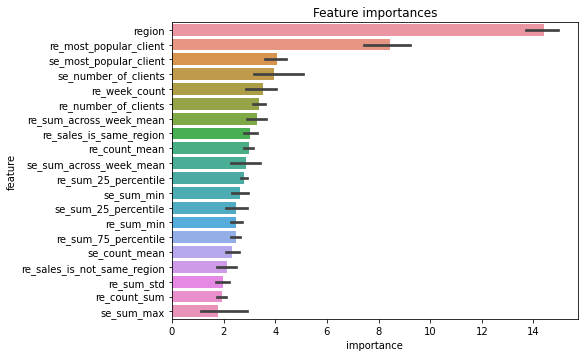

In [82]:
n_fold = 5
model = Model()
model.fit(X, y, n_fold, StratifiedKFold)

In [ ]:
y_pred = model.predict(X_test)
submission = pd.DataFrame(data=y_pred,  columns=["okved2"], index=X_test.index)
submission.to_csv('submission.csv')